In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [20]:
import logging
import logging.config
import configparser
import os
import time
from pathlib import Path
import signal
from cachepath import CachePath, TempPath, Path
import requests
import shutil
from datetime import datetime
from ratelimiter import RateLimiter

import lmsquery
from waveshare_epd import epd5in83

In [4]:
import cfg
import epdlib

In [5]:
# this works best as a global variable
logConfig = Path(cfg.LOGCONFIG)
logging.config.fileConfig(logConfig.absolute())
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(name)s %(levelname)s: %(message)s')

logger = logging.getLogger(__name__)

In [6]:
logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [7]:
appShortName = 'slimpi'
name = 'com.txoof.'
appLongName = name+appShortName

In [8]:
def configuration(configFile=None):
    
    configDefaults = cfg.CONFIGDEFAULTS
    
    if not configFile:
         configFile = Path(cfg.CONFIGFILE)

    config = configparser.ConfigParser()
    logger.info(f'reading configuration: {configFile}')
    config.read(configFile)
    
    try:
        for section in configDefaults:
            if section not in config.sections():
                logger.debug(f'adding section: {section}')
                config.add_section(section)
            
            for option in configDefaults[section]:
                if not config.has_option(section, option):
                    logger.debug(f'missing option: {option}')
                    logger.debug(f'setting {option} to: {configDefaults[section][option]}')
                    config[section][option] = str(configDefaults[section][option])
            with open(configFile, 'w') as file:
                config.write(file)
    
    except Exception as e:
        logging.exception(f'exception on configuration file: {e}')
        raise
    
    logger.debug(f'config file contains sections: {config.sections()}')
    return config

In [9]:
def query(lms, last=0, delay=7):
    '''query the player only when a specified delay has passed
    Accepts:
        last: float - last time query was called

    Returns:
        tuple(last, lms.now_playing()
    '''
    if last==0:
        last = time.clock_gettime(time.CLOCK_MONOTONIC)-delay

    if time.clock_gettime(time.CLOCK_MONOTONIC) > last+delay:
        return time.clock_gettime(time.CLOCK_MONOTONIC), lms.now_playing()

    else:
        return last, None

In [10]:
def cacheArt(query={}):
    if not query:
        return None
    
    cachePath = CachePath(appLongName, dir=True)
    required = ['artwork_url', 'album_id'] 
    missing = []
    
    for key in required:
        if not key in query:
            missing.append(key)
    if missing:
        logger.warning(f'required value(s) in `query` missing: {missing}')
        return None
    
    albumArtFile = cachePath/(query['album_id']+'.jpg')
    
    # check if file already exists in cache
    if albumArtFile.exists():
        logging.debug(f'album artwork already downloaded at: {albumArtFile}')
        return albumArtFile
    
    r = False
    albumArtURL = query['artwork_url']
    
    # try to fetch the album art
    try:
        r = requests.get(albumArtURL, stream=True)
    except requests.exceptions.RequestException as e:
        logging.error(f'failed to fetch artwork at {albumArtURL}: {e}')
        
    if r:
        try:
            with open(albumArtFile, 'wb') as outFile:
                shutil.copyfileobj(r.raw, outFile)
                logging.debug(f'wrote album art to: {albumArtFile}')
        except (OSError, FileExistsError, ValueError) as e:
            logging.error(f'failed to write {albumArtFile}: {e}')
    else:
        logging.error('skipping download of album artwork due to previous errors')

    return albumArtFile
    

In [11]:
class signalHandler(object):
    '''handle specific signals and allow graceful exiting while loop
    https://stackoverflow.com/a/31464349/5530152
    
    Signals Handled Gracefully:
        SIGINT
        SIGTERM
    Atributes:
        kill_now (bool) default: False
    '''
    kill_now = False
    def __init__(self):
        signal.signal(signal.SIGINT, self.exit_gracefully)
        signal.signal(signal.SIGTERM, self.exit_gracefully)
    
    def exit_gracefully(self, signum, frame):
        self.kill_now = True

In [12]:
def limit_callback(until):
        duration = int(round(until - time.time()))
        logging.debug(f'function call rate limited sleeping for {duration} seconds')

In [13]:
def time_now():
    return datetime.now().strftime("%H:%M")

In [14]:
def new_main():
    '''main entry point'''
    
    
    
    # set up the log level
    logger.info('starting program')
    config = configuration()

    sigHandler = signalHandler()

    # now playing fields to use
    fields = ['title', 'album', 'artist', 'mode', 'artwork_url']
    
    # lms server configuration
    lms = lmsquery.LMSQuery(player_id=config.get('server', 'player'))
    
    # create the screen object for managing screen writing
    screen = epdlib.Screen()
    screen.epd = epd5in83.EPD()
#     screen.initEPD()

    # layout for music output - 
    # FIXME - this shouldn't be hard coded here
    music_layout = epdlib.Layout(layout=epdlib.layouts.threeRow)
    music_layout.update_contents(query(lms, 0)[1])
    
    # layout for clock output
    # FIXME - this shouldn't be hard coded here
    clock_layout = epdlib.Layout(layout=epdlib.layouts.clock)
#     clock_layout.update_contents({'time': datetime.now().strftime("%H:%M"), 'mode': 'stop'})
    clock_layout.update_contents({'time': time_now(), 'mode': ' '})

    
    screen.initEPD()
    screen.elements=music_layout.blocks.values()
    
    refresh = False
    updated = 0
    last_update = 0
    
    nowplaying_id = None
    nowplaying_mode = None
    lmsQuery_ratelimit = RateLimiter(max_calls=1, period=3, callback=limit_callback)
    
    try:
        while not sigHandler.kill_now:
            response = None
            logging.debug('querying lms server')
            with lmsQuery_ratelimit:
                response = lms.now_playing()
            
            # check for a response
            if response:
                logging.info(f'mode: {response["mode"]}')
                if response['id'] != nowplaying_id or response['mode'] != nowplaying_mode:
                    logging.info('track change')
                    nowplaying_id = response['id']
                    nowplaying_mode = response['mode']
                    
                    albumArt = cacheArt(response)
                    if not albumArt:
                        albumArt = cfg.NOIMAGE
                    
                    # add the path to the album art into the response
                    response['coverart'] = str(albumArt)
                             
                    music_layout.update_contents(response)
                    refresh = music_layout
                else:
                    refresh = False
                    
            if nowplaying_mode != 'play' and screen.update.last_updated > 10:
                logging.debug('music appears to be paused')
                clock_layout.update_contents({'time': time_now(), 'mode': nowplaying_mode})
                refresh = clock_layout
#             else:
#                 refresh = False
            
            if refresh:
                logging.debug('refreshing display')
                screen.initEPD()
                screen.elements=refresh.blocks.values()
                screen.concat()
                screen.writeEPD()   
                refresh = False
            
            time.sleep(0.5)
    finally:
        logging.info("cleaning up")
        screen.initEPD()
        screen.clearEPD()

In [21]:
new_main()

<ipython-input-14-f3842bd00453>:new_main:7:INFO - starting program
<ipython-input-8-4275f2380fdc>:configuration:9:INFO - reading configuration: servercfg.ini
<ipython-input-8-4275f2380fdc>:configuration:30:DEBUG - config file contains sections: ['server', 'screen']
Layout:__init__:92:INFO - create layout
Layout:layout:193:DEBUG - calculating values from layout for resolution (600, 448)
Layout:_calculate_layout:226:INFO - ***title***
Layout:_check_keys:109:DEBUG - checking key/values
Layout:_check_keys:114:DEBUG - missing key: rand; adding and setting to False
Layout:_check_keys:114:DEBUG - missing key: inverse; adding and setting to False
Layout:_check_keys:114:DEBUG - missing key: dimensions; adding and setting to None
Layout:_calculate_layout:233:DEBUG - dimensions: (600, 256)
Layout:_calculate_layout:262:DEBUG - has explict position
Layout:_calculate_layout:264:DEBUG - abs_coordinates: (0, 0)
Layout:_scalefont:135:DEBUG - calculating font size
Layout:_scalefont:136:DEBUG - using fon

Block:_text2image:409:DEBUG - h-center image coordinates
Block:_text2image:414:DEBUG - v-center image coordinates
Block:_text2image:418:DEBUG - image coordinates (150, 92)
Layout:update_contents:324:DEBUG - updating block: artist
Block:text_formatter:347:DEBUG - formatted list:
 ['The David [...]']
Block:_text2image:364:DEBUG - random is set: False
Block:_text2image:377:DEBUG - text image dimensions: (263, 50)
Block:_text2image:414:DEBUG - v-center image coordinates
Block:_text2image:418:DEBUG - image coordinates (240, 263)
Layout:update_contents:327:DEBUG - ignoring block coverid
Layout:update_contents:327:DEBUG - ignoring block duration
Layout:update_contents:327:DEBUG - ignoring block album_id
Layout:update_contents:327:DEBUG - ignoring block genre
Layout:update_contents:324:DEBUG - updating block: album
Block:text_formatter:347:DEBUG - formatted list:
 ['DGQ-20']
Block:_text2image:364:DEBUG - random is set: False
Block:_text2image:377:DEBUG - text image dimensions: (151, 51)
Block:

Layout:update_contents:324:DEBUG - updating block: coverart
Block:image:178:DEBUG - formatting image: /tmp/com.txoof.slimpi/5133.jpg
Block:image:180:DEBUG - set image dimensions: 182
Block:image:210:DEBUG - set img_coordinates: (29, 274)
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (150, 92)
Screen:concat:150:DEBUG - pasting image at: (29, 274)
Screen:concat:150:DEBUG - pasting image at: (240, 263)
Screen:concat:150:DEBUG - pasting image at: (240, 326)
Screen:concat:150:DEBUG - pasting image at: (240, 384)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG - close

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

Block:_text2image:398:DEBUG - setting random position within area
Layout:update_contents:324:DEBUG - updating block: mode
Block:text_formatter:347:DEBUG - formatted list:
 ['pause']
Block:_text2image:364:DEBUG - random is set: True
Block:_text2image:377:DEBUG - text image dimensions: (97, 41)
Block:_text2image:398:DEBUG - setting random position within area
<ipython-input-14-f3842bd00453>:new_main:81:DEBUG - refreshing display
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Screen:concat:150:DEBUG - pasting image at: (0, 0)
Screen:concat:150:DEBUG - pasting image at: (0, 392)
Screen:concat:150:DEBUG - pasting image at: (0, 441)
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG -

In [ ]:
def main():
    '''main entry point
    '''   
    logger.setLevel(logging.DEBUG)
    logger.info('Starting program')
    config = configuration()
    # scan for lms server and use the first one (this may be a terrible idea for other people)
#     lmsServer = lmsquery.scanLMS()[0]
    
    # define LMS query object
#     lms = lmsquery.LMSQuery(lmsServer['host'], lmsServer['port'], config.get('server', 'player'))
    lms = lmsquery.LMSQuery(player_id=config.get('server', 'player'))
    
    screen = epdlib.Screen()
    screen.epd = epd5in83.EPD()
    screen.initEPD()
#     screen.clearEPD()
    music_layout = epdlib.Layout(layout=epdlib.layouts.threeRow)
    music_layout.update_contents(query(lms, 0)[1])
    
    clock_layout = epdlib.Layout(layout=epdlib.layouts.clock)
    clock_layout.update_contents({'time': datetime.now().strftime("%H:%M"), 'mode': 'stop'})
    
    screen.initEPD()
    screen.elements=music_layout.blocks.values()
#     screen.concat()
#     screen.writeEPD()    
    
    
    sigHandler = signalHandler()
    
    # last update
    updated = 0
    last_updated = 0
    
    # refresh display
    refresh = True
    # id of currently playing track
    nowPlayingID = None
    # status of player 
    nowPlayingMode = None

    # now playing fields to display
    fields = ['title', 'album', 'artist', 'mode', 'artwork_url']
    
    
    print(f'pid: {os.getpid()}')
    try:
        while not sigHandler.kill_now:
            updated, value = query(lms=lms, last=updated, delay=3)            
            response = value
            
            # if there's a response, check to see if display needs an update
            if response: 
                # if the album ID changed the player state changed, update the display
                if response['id'] != nowPlayingID or response['mode'] != nowPlayingMode:
                    last_updated = updated
                    nowPlayingID = response['id']
                    nowPlayingMode = response['mode']                    
                    
                    albumArt = cacheArt(response)
                    if not albumArt:
                        albumArt = cfg.NOIMAGE
                    
                    value['coverart'] = str(albumArt)
                    
                    music_layout.update_contents(value)
                    
                    refresh = music_layout
                else:
                    refresh=False
                    
#             logging.debug(f'last update was: {updated-last_updated} seconds ago')
            
#             if updated-last_updated > 120 and nowPlayingMode != 'play':
                
#                 clocklayout.update_contents({'time': datetime.now().strftime("%H:%M"), 'mode': 'stop'})
                    
            # refresh the display if needed    
            if refresh:
                logging.debug('refreshing display')
                screen.initEPD()
                screen.elements=refresh.blocks.values()
                screen.concat()
                screen.writeEPD()    
                refresh = false
                    
            time.sleep(0.5)
    finally:
        print("cleaning up")
        screen.initEPD()
        screen.clearEPD()
        return layout    

In [15]:
np = epdlib.Layout(layout=epdlib.layouts.threeRow)

Layout:__init__:92:INFO - create layout
Layout:layout:193:DEBUG - calculating values from layout for resolution (600, 448)
Layout:_calculate_layout:226:INFO - ***title***
Layout:_check_keys:109:DEBUG - checking key/values
Layout:_check_keys:114:DEBUG - missing key: rand; adding and setting to False
Layout:_check_keys:114:DEBUG - missing key: inverse; adding and setting to False
Layout:_check_keys:114:DEBUG - missing key: dimensions; adding and setting to None
Layout:_calculate_layout:233:DEBUG - dimensions: (600, 256)
Layout:_calculate_layout:262:DEBUG - has explict position
Layout:_calculate_layout:264:DEBUG - abs_coordinates: (0, 0)
Layout:_scalefont:135:DEBUG - calculating font size
Layout:_scalefont:136:DEBUG - using font at path: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf
Layout:_scalefont:148:DEBUG - target X font dimension 510.0
Layout:_scalefont:149:DEBUG - target Y dimension: 59.73333333333333
Layout:_scalefont:167:DEBUG - Y target exceeded
Layout:_scalefont:

In [16]:
np.update_contents({'title': 'foo', 'albumart': '/tmp/com.txoof.slimpi/5040.jpg'})

Layout:update_contents:318:DEBUG - updating blocks
Layout:update_contents:324:DEBUG - updating block: title
Block:text_formatter:347:DEBUG - formatted list:
 ['foo']
Block:_text2image:364:DEBUG - random is set: False
Block:_text2image:377:DEBUG - text image dimensions: (85, 60)
Block:_text2image:389:DEBUG - h-center line: foo
Block:_text2image:409:DEBUG - h-center image coordinates
Block:_text2image:414:DEBUG - v-center image coordinates
Block:_text2image:418:DEBUG - image coordinates (258, 98)
Layout:update_contents:327:DEBUG - ignoring block albumart


In [17]:
s = epdlib.Screen()
s.epd = epd5in83.EPD()
s.initEPD()

epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release


True

In [18]:
s.elements = np.blocks.values()

Screen:concat:150:DEBUG - pasting image at: (258, 98)
Screen:concat:150:DEBUG - pasting image at: (0, 256)
Screen:concat:150:DEBUG - pasting image at: (240, 266)
Screen:concat:150:DEBUG - pasting image at: (240, 330)
Screen:concat:150:DEBUG - pasting image at: (240, 384)


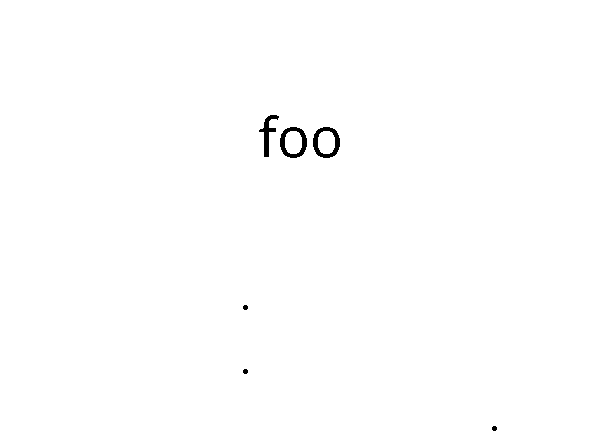

In [147]:
s.concat()

In [ ]:
if __name__ == '__main__':
    
    foo = main()

In [ ]:
    sc = epdlib.Screen()
    sc.epd = epd5in83.EPD()
    sc.initEPD()
    sc.clearEPD()

In [ ]:
sc.update.age

In [ ]:
sc.update.update = True

In [ ]:
sc.update.last_updated

In [ ]:
def clock(area=(600, 448), layout=None, mode='Stopped'):
    time = datetime.now().strftime("%H:%M")
    l = epdlib.Layout(layout)
    l.update({'time': time, 'mode': mode})
    
    pass

In [ ]:
clock(layout=epdlib.layouts.clock)

In [ ]:
tl = epdlib.Layout(layout=epdlib.layouts.clock)

In [ ]:
from PIL import Image

In [ ]:
i = Image.new('1', (600, 7), color=0)

In [ ]:
upd = {'time': datetime.now().strftime("%H:%M"), 'mode': 'Stopped'}
tl.update_contents(upd)

In [ ]:
sc.elements = tl.blocks.values()

In [ ]:
sc.concat()

In [ ]:
sc.initEPD()
sc.writeEPD()

In [ ]:
import datetime

In [ ]:
l = epdlib.Layout(resolution=(600, 392))

In [ ]:
l._scalefont(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', dimensions=(600,392))

In [ ]:
b = epdlib.Block.TextBlock(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', font_size=87, area=(600, 392))

In [ ]:
help(b)

In [ ]:
t = datetime.datetime.now().time()
timeStr = f'{t.hour}:{t.minute}'